### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet

import re
import spacy

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
#Install pyspellchecker module, if does not exists, 
#this module is a Pure Python Spell Checking based on Peter Norvig’s blog post on setting up a simple spell checking algorithm.

#!pip install pyspellchecker

In [3]:
#install Spacy library for advanced natural language processing, this will be used to perform lemmatization
#!pip install spacy

### Data Load

In [4]:
path = r'..\Data\01_Clean_Review_Data.json'
Review_DF = pd.read_json(path)

In [5]:
Review_DF['Review_Date'] = pd.to_datetime(Review_DF['Review_Date'])

In [6]:
Review_DF.head()

,User_ID,Product_ID,User_Name,Rating_Helpfulness,Text_Review,Ratings,Review_Summary,Review_Timestamp_Unix,Review_Date
131660,A3RV1L35IPTV61,B009SK5B3O,abushaheed,"[1, 1]",It feels solid and so far it's getting the job...,4,It's what it is,1379808000,2013-09-22
10959,A24Y4T8OCYTDYQ,B002GICEXK,Siphandone,"[0, 0]",It's a bad and used battery even though it was...,1,Bad and used battery,1312761600,2011-08-08
25016,A2EOGNVR0WUNMD,B00404UR3C,K. Ray,"[0, 0]","With these Screen Protectors, three issues are...",5,Nice screen protector,1346457600,2012-09-01
184052,A25FWNLV27N3W3,B00GCQMZVS,CCot,"[0, 0]",It doesn't live up to the Lifeproof name. Its ...,3,Doesn't live up to Lifeproof name.,1388620800,2014-01-02
16828,A27ODY4C2RMOQ7,B003MS83KG,JB,"[0, 0]","This screen replacement did not fit correctly,...",1,"Doesn't fit, and is defective",1372118400,2013-06-25


## Preprocessing - Text Normalization

Text Normalization(Text wrangling or cleansing) is a process of transforming text into a form that can be used by NLP and analytics systems and applications as input. It can consist of various steps like:-
* Tokenization 
* Cleaning text 
* Removing Special Characters
* Correcting spelling 
* Removing stopwords, punctuations or unwanted tokens
* Case conversion 
* Stemming
* Lemmatization.

#### 1: Tokenization

Tokenization is the process of transforming a string or document into smaller chunks, which we call tokens. This is usually one step in the process of preparing a text for natural language processing. 

**Sentence Tokenization** is a process of converting text corpus into sentences which is the first level of tokens. This is also called Sentence Segmentation because we try to segment the text into meaningful sentences.

**Word Tokenization** is a process of splitting sentences into words.

In [7]:
# Defined Tokenization fuction
# The following function will take any sentence and convert it into word tokens
# Then strip leading and trailing spaces

def Tokenize_Text(text):
    word_tokens = word_tokenize(text)
    tokens = [token.strip() for token in word_tokens]
    return tokens

#### 2: Removing Special Characters
One important task in text normalization involves removing unnecessary and special characters. These may be special symbols or punctuations that occurs in sentences. <br>
Special Characters and symbols are usually non-alphanumeric characters or even occaionally numeric characters(depending on the problem) which adds extra noise to unstructured text data and does not add much significance while analyzing text and untilzing it for feature extraction. [Link](https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72)

In [8]:
import re

# Defined function will strip leading and trailing spaces 
# Looks for special characters, replace with space
# returning only apha characters

def Remove_Special_Characters(text):
    text = text.strip()
    pattern = '[^a-zA-z]'
    filtered_text = re.sub(pattern, ' ', text) #Replace matches with spaces
    return filtered_text

#### 3: Removing Stop Words
Stopwords are the words that has little or no significance especially when consturcting meaningful features from text. They are removed from the text so that we are left with words having maximum significance. <br>
They are usually words that have maximum frequency if you aggregate any corpus of text based on singular tokens. <br>
Ex:- a, the, of and so on.

In [9]:
#If nltk stopwords does not exist, uncomment and run
#nltk.download('stopwords') 

In [10]:
from nltk.corpus import stopwords

#In Python, searching through set is much faster than list.
stopword_set = set(stopwords.words("english"))

# Defined function will romove remove stopwords
# Here, words not in stopword corpus will be kept

def Remove_Stopwords(tokens):
    filtered_tokens = [token for token in tokens if token not in stopword_set]
    return filtered_tokens

#### 4: Correcting Words
Incorrect spellings are very normal and also one of the main challeges faced in Text Normalization. The definition of incorrect here covers words that have spelling mistakes as well as words with several letters repeated that do not contribute much to its overall significance.
##### 4.1 Correcting Repeating Characters

In [11]:
#If got LookupError(nltk stopwords does not exist), uncomment and run
#nltk.download('wordnet') 

In [12]:
from nltk.corpus import wordnet

# Defined function to remove repeated characters

def Remove_Repeated_Characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)') #Regex object to look for repeated charaters
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if(wordnet.synsets(old_word)):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word) # substitutes a wrong spelling like "Hellooooo" to "Hello"
        return replace(new_word) if new_word != old_word else new_word # Replaces repeating characters, till there are none left

    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens

##### 4.2 Correcting Spellings 
[How to Write Spelling Corrector](https://norvig.com/spell-correct.html)

In [13]:
from collections import Counter

#Generate a word vocabulary, which will be used as a reference to check the spelling using a file containing severl books from 
#Gutenberg corpus and also list of most frequent words from wiktionary and British National Corpus. You can download it from
# http://norvig.com/big.txt

def tokens(text):
    return re.findall('[a-z]+', text.lower())

path = '../Raw_Data/big.txt'

with open(path) as file:
    document = file.read()

words = tokens(document)
word_counts = Counter(words)

In [14]:
# Define functions that compute sets of words that are one and two edits away from input word.
def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [15]:
# Defining function that returns a subset of words from our candidate set of words obtained from 
# the edit functions, based on whether they occur in our vocabulary dictionary word_counts.
# This gives us a list of valid words from our set of candidate words.

def known(words): 
    "The subset of `words` that appear in the dictionary of word_counts."
    return set(w for w in words if w in word_counts)

In [16]:
# Define function to correct words
def Correct_Words(words):
    # Get the best correct spellings for the input words
    def candidates(word): 
        # Generate possible spelling corrections for word.
        # Priority is for edit distance 0, then 1, then 2, else defaults to the input word itself.
        candidates = known([word]) or known(edits1(word)) or known(edits2(word)) or [word]
        return candidates
    
    corrected_words = [max(candidates(word), key=word_counts.get) for word in words]
    return corrected_words

#### 5: Lemmatization 
[Lemmatization vs Stemming](https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/)

It is process of removing affixes from the word to get that into its base form. The base form of the word is also called as the root word and will always be present in the dictionay. 

In [17]:
# You may get OSError:[E050] Can't find model 'en_core_web_sm'
# Open anaconda prompt and run "python -m spacy download en_core_web_sm"
nlp = spacy.load("en_core_web_sm")

In [18]:
# Defined function for lemmatization

def Lemmatize_Tokens(tokens):
    doc = ' '.join(tokens) # Creates a string doc seperated with spaces 
    Lemmatized_tokens = [token.lemma_ for token in nlp(doc)] # looks for lemma for each word
    return Lemmatized_tokens

#### 7: Text Normalization

In [19]:
def Normalize_Text_Corpus(corpus):
    normalized_corpus = []
    for text in corpus:
        text = text.lower()
        text = Remove_Special_Characters(text)
        tokens = Tokenize_Text(text)
        tokens = Remove_Stopwords(tokens)
        tokens = Remove_Repeated_Characters(tokens)
        tokens = Correct_Words(tokens)
        tokens = Lemmatize_Tokens(tokens)
        text = ' '.join(tokens)
        normalized_corpus.append(text)
    return normalized_corpus

In [20]:
Normalized_Reviews = Normalize_Text_Corpus(Review_DF.Text_Review)

In [21]:
Review_DF = Review_DF.assign(Normalized_Reviews = Normalized_Reviews)

In [22]:
# Saving Normalized Reviews Data Set
path = '../Data/Normalized_Dataset.csv'
Review_DF.to_csv(path)

-------------------------------------------------------------------------------------------------------------------------------
## Feature Engineering 
It is process of creating features for machine learning models from Raw Text Data.[Link](https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d#:~:text=NLP%20is%20often%20applied%20for,model%20from%20raw%20text%20data.)
* Bag of Words
* TF-IDF 
* Average Word Vectors
* TF-IDF Weighted Average Word Vectors

#### 1: Bag of Words Model
Bag of words is a very simple and basic method to finding topics in a text. For bag of words you need to tokenize the sentences and the count the occurence of each word. <br> The more frequent a word or token is, the more central or important it might be to the text. Bag of words can be a great way to determine the significant words in a text, based on the number of times they are used. <br> Documents are describe by the word occurence and while completely ignoring the relative position information of the words in the document.

**Vectorization** It is a general process of converting text documents into numerical feature vectors. 

**Corpus:** Set of large and structured set of text that are used to do statistical analysis and hypothesis testing, checking occurrences or validating linguistic rules within a specific language territory.

In [23]:
#Defining the fuction to generate bag of words, which take text corpus as input.
#Count Vectorizer, implements both tokenization and occurence counting in a single class

def Bag_of_Words(corpus):
    vectorizer = CountVectorizer()
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

#### 2: TF-IDF Model
In TF-IDF model, TF stands for Token(Term) Frequency and IDF stands for Inverse document frequency.
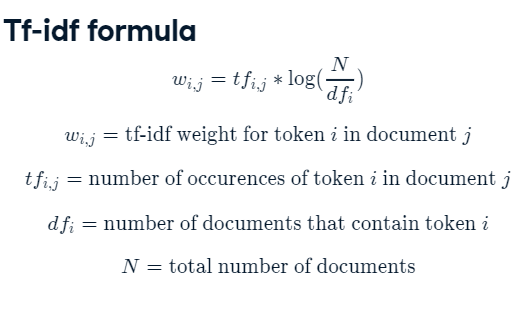

In [24]:
#Defining the function to compute tfidf based feature vectors for documents.

def tfidf(corpus):
    vectorizer = TfidfVectorizer()
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

#### 3: Average Word Vector

In [25]:
# Define function to average word vectors for a text document

def Average_Word_Vectors(sentence, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features),dtype="float64")
    nwords = 0.
    
    for word in sentence:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

In [26]:
# Generalize above function for a corpus of documents  

def Average_Word_Vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    #print(vocabulary)
    features = [Average_Word_Vectors(sentence, model, vocabulary, num_features) for sentence in corpus]
    return np.array(features)

#### 4: TF-IDF Weighted Average word Vectors

In [27]:
# Define function to compute tfidf weighted averaged word vector for a document

def tfidf_wtd_avg_word_vectors(words, tfidf_vector, tfidf_vocabulary, model, num_features):
    
    word_tfidfs = [tfidf_vector[0, tfidf_vocabulary.get(word)] 
                   if tfidf_vocabulary.get(word) 
                   else 0 for word in words]    
    word_tfidf_map = {word:tfidf_val for word, tfidf_val in zip(words, word_tfidfs)}
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    vocabulary = set(model.wv.index2word)
    wts = 0.
    for word in words:
        if word in vocabulary: 
            word_vector = model.wv[word]
            weighted_word_vector = word_tfidf_map[word] * word_vector
            wts = wts + word_tfidf_map[word]
            feature_vector = np.add(feature_vector, weighted_word_vector)
    if wts:
        feature_vector = np.divide(feature_vector, wts)
        
    return feature_vector

In [28]:
# Generalize above function for a corpus of documents

def tfidf_weighted_averaged_word_vectorizer(corpus, tfidf_vectors, 
                                   tfidf_vocabulary, model, num_features):
                                       
    docs_tfidfs = [(doc, doc_tfidf) 
                   for doc, doc_tfidf 
                   in zip(corpus, tfidf_vectors)]
    features = [tfidf_wtd_avg_word_vectors(tokenized_sentence, tfidf, tfidf_vocabulary,
                                   model, num_features)
                    for tokenized_sentence, tfidf in docs_tfidfs]
    return np.array(features)

-------------------------------------------------------------------------------------------------------------------------------
## Train Test Split

In [29]:
# Splitting the dataset into training and testing set. 
# As we have imbalanced data, with mostly products rated 5, we will use stratified split.

X = Review_DF['Normalized_Reviews']
y = Review_DF['Ratings']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 7, stratify = y)

print("Shape of train_X: ", train_X.shape)
print("Shape of train_y: ", train_y.shape)
print("Shape of test_X: ", test_X.shape)
print("Shape of test_y: ", test_y.shape)

Shape of train_X:  (12000,)
Shape of train_y:  (12000,)
Shape of test_X:  (3000,)
Shape of test_y:  (3000,)


-------------------------------------------------------------------------------------------------------------------------------
## Feature Extraction for train and test splits


In [30]:
# Define function to display feature names

def display_features(features, feature_names):
    df = pd.DataFrame(data=features,
                      columns=feature_names)
    print (df)

#### 1: Bag of words

In [31]:
# bag of words features

feature_set = []
bow_Vectorizer, bow_train_features = Bag_of_Words(train_X) #Generating Feature vector and bow_vectorizer
bow_test_features = bow_Vectorizer.transform(test_X)  
feature_set.append(('Bag of words features', bow_train_features, bow_test_features))

In [32]:
#Printing Feature Names

feature_names = bow_Vectorizer.get_feature_names()
print(feature_names)

['ab', 'abacus', 'abandon', 'abbreviate', 'abbreviation', 'abc', 'abe', 'abelkin', 'ability', 'able', 'abolish', 'about', 'abrasion', 'abreast', 'abroad', 'absence', 'absent', 'absolute', 'absolutely', 'absolutism', 'absorb', 'absorbent', 'absorbing', 'absorption', 'abstract', 'absurd', 'abundance', 'abuse', 'abusive', 'abut', 'abysmal', 'ac', 'acadia', 'accelerate', 'accelerometer', 'accent', 'accentuate', 'accept', 'acceptability', 'acceptable', 'access', 'accessed', 'accessible', 'accessory', 'accident', 'accidental', 'accidentally', 'accidently', 'accommodate', 'accommodation', 'accompany', 'accomplish', 'accomplished', 'accord', 'accordance', 'according', 'accordingly', 'account', 'accumulate', 'accumulation', 'accuracy', 'accurate', 'accurately', 'accuse', 'accustom', 'accustomed', 'ace', 'acescase', 'aceserie', 'acesiblecamera', 'acesorie', 'acesoriesthis', 'acesorize', 'acesoryenjoy', 'ache', 'achieve', 'achieveable', 'acid', 'acknowledge', 'acomodate', 'acomodatingcon', 'acous

In [33]:
# Converting Features array to matrix

bow_features_mat = bow_train_features.todense()

# Printing first 5 rows Features and vectors Dataframe
display_features(bow_features_mat[0:5], feature_names)

   ab  abacus  abandon  abbreviate  abbreviation  abc  abe  abelkin  ability  \
0   0       0        0           0             0    0    0        0        0   
1   0       0        0           0             0    0    0        0        0   
2   0       0        0           0             0    0    0        0        0   
3   0       0        0           0             0    0    0        0        0   
4   0       0        0           0             0    0    0        0        0   

   able  ...  yuri  zen  zero  zerolemomn  zerolemon  zip  ziplock  zis  zone  \
0     0  ...     0    0     0           0          0    0        0    0     0   
1     0  ...     0    0     0           0          0    0        0    0     0   
2     1  ...     0    0     0           0          0    0        0    0     0   
3     0  ...     0    0     0           0          0    0        0    0     0   
4     0  ...     0    0     0           0          0    0        0    0     0   

   zukyju  
0       0  
1       

#### 2: TF-IDF 

In [34]:
# tfidf features

tfidf_vectorizer, tfidf_train_features = tfidf(train_X)  
tfidf_test_features = tfidf_vectorizer.transform(test_X)
feature_set.append(('Tfidf features', tfidf_train_features, tfidf_test_features))

In [35]:
# Print feature names

feature_names = tfidf_vectorizer.get_feature_names()
print (feature_names)

['ab', 'abacus', 'abandon', 'abbreviate', 'abbreviation', 'abc', 'abe', 'abelkin', 'ability', 'able', 'abolish', 'about', 'abrasion', 'abreast', 'abroad', 'absence', 'absent', 'absolute', 'absolutely', 'absolutism', 'absorb', 'absorbent', 'absorbing', 'absorption', 'abstract', 'absurd', 'abundance', 'abuse', 'abusive', 'abut', 'abysmal', 'ac', 'acadia', 'accelerate', 'accelerometer', 'accent', 'accentuate', 'accept', 'acceptability', 'acceptable', 'access', 'accessed', 'accessible', 'accessory', 'accident', 'accidental', 'accidentally', 'accidently', 'accommodate', 'accommodation', 'accompany', 'accomplish', 'accomplished', 'accord', 'accordance', 'according', 'accordingly', 'account', 'accumulate', 'accumulation', 'accuracy', 'accurate', 'accurately', 'accuse', 'accustom', 'accustomed', 'ace', 'acescase', 'aceserie', 'acesiblecamera', 'acesorie', 'acesoriesthis', 'acesorize', 'acesoryenjoy', 'ache', 'achieve', 'achieveable', 'acid', 'acknowledge', 'acomodate', 'acomodatingcon', 'acous

In [36]:
features = tfidf_train_features.todense()
features_tfidf = np.round(features, 2)
display_features(features_tfidf[0:5], feature_names)

    ab  abacus  abandon  abbreviate  abbreviation  abc  abe  abelkin  ability  \
0  0.0     0.0      0.0         0.0           0.0  0.0  0.0      0.0      0.0   
1  0.0     0.0      0.0         0.0           0.0  0.0  0.0      0.0      0.0   
2  0.0     0.0      0.0         0.0           0.0  0.0  0.0      0.0      0.0   
3  0.0     0.0      0.0         0.0           0.0  0.0  0.0      0.0      0.0   
4  0.0     0.0      0.0         0.0           0.0  0.0  0.0      0.0      0.0   

   able  ...  yuri  zen  zero  zerolemomn  zerolemon  zip  ziplock  zis  zone  \
0   0.0  ...   0.0  0.0   0.0         0.0        0.0  0.0      0.0  0.0   0.0   
1   0.0  ...   0.0  0.0   0.0         0.0        0.0  0.0      0.0  0.0   0.0   
2   0.1  ...   0.0  0.0   0.0         0.0        0.0  0.0      0.0  0.0   0.0   
3   0.0  ...   0.0  0.0   0.0         0.0        0.0  0.0      0.0  0.0   0.0   
4   0.0  ...   0.0  0.0   0.0         0.0        0.0  0.0      0.0  0.0   0.0   

   zukyju  
0     0.0  
1 

#### 3: Average Word Vector 

In [37]:
# tokenize documents
tokenized_train = [nltk.word_tokenize(text) for text in train_X]
tokenized_test = [nltk.word_tokenize(text) for text in test_X]

In [38]:
import gensim

# build word2vec model                   
model = gensim.models.Word2Vec(tokenized_train,
                               size=5000,
                               min_count=2)

In [39]:
# averaged word vector features
avg_wv_train_features = Average_Word_Vectorizer(corpus=tokenized_train,
                                                 model=model,
                                                 num_features=5000)                   
avg_wv_test_features = Average_Word_Vectorizer(corpus=tokenized_test,
                                                model=model,
                                                num_features=5000) 
feature_set.append(('Averaged word vector features', avg_wv_train_features, avg_wv_test_features))

In [40]:
# Print test features
print (np.round(avg_wv_test_features, 3))

[[ 0.037  0.011 -0.051 ...  0.044  0.029  0.03 ]
 [ 0.057  0.013 -0.029 ...  0.016  0.018  0.045]
 [ 0.015  0.014 -0.066 ...  0.053  0.035  0.078]
 ...
 [ 0.079  0.049 -0.073 ...  0.009  0.01   0.029]
 [ 0.059  0.043 -0.017 ...  0.021  0.013  0.085]
 [ 0.051  0.031 -0.05  ...  0.008  0.021  0.054]]


#### 4: TF-IDF Weighted Average Word Vector

In [41]:
# tfidf weighted averaged word vector features
vocab = tfidf_vectorizer.vocabulary_
tfidf_wv_train_features = tfidf_weighted_averaged_word_vectorizer(corpus=tokenized_train, 
                                                                  tfidf_vectors=tfidf_train_features, 
                                                                  tfidf_vocabulary=vocab, 
                                                                  model=model, 
                                                                  num_features=5000)
tfidf_wv_test_features = tfidf_weighted_averaged_word_vectorizer(corpus=tokenized_test, 
                                                                 tfidf_vectors=tfidf_test_features, 
                                                                 tfidf_vocabulary=vocab, 
                                                                 model=model, 
                                                                 num_features=5000)
feature_set.append(('Tfidf weighted averaged word vector features', tfidf_wv_train_features, tfidf_wv_test_features))

In [42]:
# Print test features
print (np.round(tfidf_wv_test_features, 3))

[[ 0.041  0.014 -0.01  ...  0.056  0.047  0.041]
 [ 0.057  0.026 -0.013 ...  0.008  0.011  0.063]
 [ 0.006  0.019 -0.048 ...  0.044  0.033  0.081]
 ...
 [ 0.075  0.045 -0.076 ...  0.012  0.008  0.026]
 [ 0.06   0.04  -0.017 ...  0.018  0.011  0.074]
 [ 0.047  0.027 -0.043 ...  0.008  0.022  0.046]]


-------------------------------------------------------------------------------------------------------------------------------
##  Function for Evaluating Models

In [43]:
from sklearn.metrics import accuracy_score, classification_report

def scoring_metrics(true_labels, predicted_labels):
    print ('Accuracy: ', accuracy_score(true_labels,predicted_labels))
    print (classification_report(true_labels, predicted_labels))

-------------------------------------------------------------------------------------------------------------------------------
## Models

### Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
results = []
for f_name, train_feature, test_feature in feature_set:

    LR_Model = LogisticRegression()
    LR_Model.fit(train_feature, train_y)
    train_pred = LR_Model.predict(train_feature)
    test_pred = LR_Model.predict(test_feature)
    print("======================================================")
    print("Model: Logistic Regression")
    print(f_name)
    print("Training Set Performance: ")
    scoring_metrics(true_labels = train_y, predicted_labels = train_pred)
    print("Test Set Performance: ")
    scoring_metrics(true_labels = test_y, predicted_labels = test_pred)   
    results.append(("LogisticRegression", f_name, test_pred))

C:\DataScience\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Bag of words features
Training Set Performance: 
Accuracy:  0.86
              precision    recall  f1-score   support

           1       0.90      0.87      0.88       826
           2       0.93      0.73      0.82       700
           3       0.87      0.71      0.78      1308
           4       0.88      0.67      0.76      2460
           5       0.84      0.97      0.90      6706

    accuracy                           0.86     12000
   macro avg       0.89      0.79      0.83     12000
weighted avg       0.86      0.86      0.85     12000

Test Set Performance: 
Accuracy:  0.5956666666666667
              precision    recall  f1-score   support

           1       0.49      0.45      0.47       207
           2       0.22      0.15      0.18       175
           3       0.32      0.25      0.28       327
           4       0.39      0.28      0.32       615
           5       0.71      0.84      0.77      1676

    accuracy                           0

C:\DataScience\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Tfidf features
Training Set Performance: 
Accuracy:  0.7131666666666666
              precision    recall  f1-score   support

           1       0.77      0.56      0.65       826
           2       0.86      0.17      0.29       700
           3       0.71      0.35      0.47      1308
           4       0.68      0.42      0.52      2460
           5       0.71      0.97      0.82      6706

    accuracy                           0.71     12000
   macro avg       0.75      0.49      0.55     12000
weighted avg       0.72      0.71      0.68     12000

Test Set Performance: 
Accuracy:  0.617
              precision    recall  f1-score   support

           1       0.60      0.38      0.46       207
           2       0.17      0.01      0.02       175
           3       0.40      0.17      0.24       327
           4       0.42      0.25      0.31       615
           5       0.66      0.93      0.78      1676

    accuracy                           0.62   

C:\DataScience\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Averaged word vector features
Training Set Performance: 
Accuracy:  0.5765833333333333
              precision    recall  f1-score   support

           1       0.46      0.19      0.27       826
           2       0.67      0.00      0.01       700
           3       0.33      0.04      0.06      1308
           4       0.39      0.10      0.16      2460
           5       0.59      0.96      0.74      6706

    accuracy                           0.58     12000
   macro avg       0.49      0.26      0.25     12000
weighted avg       0.52      0.58      0.47     12000

Test Set Performance: 
Accuracy:  0.5746666666666667
              precision    recall  f1-score   support

           1       0.48      0.20      0.29       207
           2       1.00      0.01      0.01       175
           3       0.36      0.05      0.09       327
           4       0.37      0.09      0.15       615
           5       0.59      0.96      0.73      1676

    accuracy      

C:\DataScience\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Tfidf weighted averaged word vector features
Training Set Performance: 
Accuracy:  0.57225
              precision    recall  f1-score   support

           1       0.47      0.16      0.24       826
           2       0.43      0.01      0.02       700
           3       0.32      0.04      0.07      1308
           4       0.39      0.07      0.12      2460
           5       0.59      0.97      0.73      6706

    accuracy                           0.57     12000
   macro avg       0.44      0.25      0.24     12000
weighted avg       0.50      0.57      0.46     12000

Test Set Performance: 
Accuracy:  0.569
              precision    recall  f1-score   support

           1       0.38      0.14      0.20       207
           2       0.25      0.01      0.01       175
           3       0.42      0.04      0.07       327
           4       0.39      0.07      0.11       615
           5       0.58      0.97      0.73      1676

    accuracy               

### RandomForestClassifier

In [45]:
from sklearn.ensemble import RandomForestClassifier

for f_name, train_feature, test_feature in feature_set:
    print("======================================================")
    print("Model: RandomForestClassifier")
    print(f_name)
    RFC_Model = RandomForestClassifier()
    RFC_Model.fit(train_feature, train_y)
    train_pred = RFC_Model.predict(train_feature)
    test_pred = RFC_Model.predict(test_feature)    
    print("Training Set Performance: ")
    scoring_metrics(true_labels = train_y, predicted_labels = train_pred)
    print("Test Set Performance: ")
    scoring_metrics(true_labels = test_y, predicted_labels = test_pred) 
    results.append(("RandomForestClassifier", f_name, test_pred))

Model: RandomForestClassifier
Bag of words features
Training Set Performance: 
Accuracy:  0.9999166666666667
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       826
           2       1.00      1.00      1.00       700
           3       1.00      1.00      1.00      1308
           4       1.00      1.00      1.00      2460
           5       1.00      1.00      1.00      6706

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000

Test Set Performance: 
Accuracy:  0.5856666666666667
              precision    recall  f1-score   support

           1       0.71      0.17      0.28       207
           2       0.67      0.01      0.02       175
           3       0.44      0.05      0.09       327
           4       0.48      0.09      0.15       615
           5       0.59      0.98      0.74      1676

    accuracy           

C:\DataScience\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Set Performance: 
Accuracy:  0.9999166666666667
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       826
           2       1.00      1.00      1.00       700
           3       1.00      1.00      1.00      1308
           4       1.00      1.00      1.00      2460
           5       1.00      1.00      1.00      6706

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000

Test Set Performance: 
Accuracy:  0.567
              precision    recall  f1-score   support

           1       0.43      0.19      0.27       207
           2       0.20      0.01      0.02       175
           3       0.28      0.06      0.09       327
           4       0.31      0.12      0.17       615
           5       0.60      0.94      0.73      1676

    accuracy                           0.57      3000
   macro avg       0.36      0.26 

-------------------------------------------------------------------------------------------------------------------------------
## Confusion Matrix

In [46]:
from sklearn.metrics import confusion_matrix

for m_name, f_name, predictions in results:
    print("Model {} with {}:".format(m_name, f_name))
    cm = confusion_matrix(test_y, predictions)
    print(pd.DataFrame(cm, index=range(1,6), columns=range(1,6)))
    print()

Model LogisticRegression with Bag of words features:
    1   2   3    4     5
1  93  29  20   14    51
2  34  26  33   21    61
3  28  29  81   63   126
4  11  15  72  171   346
5  22  18  48  172  1416

Model LogisticRegression with Tfidf features:
    1  2   3    4     5
1  78  2  15   14    98
2  23  2  25   34    91
3  15  4  55   73   180
4   6  3  31  154   421
5   7  1  12   94  1562

Model LogisticRegression with Averaged word vector features:
    1  2   3   4     5
1  42  0   3   5   157
2  12  1   4  15   143
3  12  0  16  32   267
4   7  0  11  57   540
5  14  0  10  44  1608

Model LogisticRegression with Tfidf weighted averaged word vector features:
    1  2   3   4     5
1  28  0   2   5   172
2  12  1   4  10   148
3  12  1  13  19   282
4   8  0   6  40   561
5  14  2   6  29  1625

Model RandomForestClassifier with Bag of words features:
    1  2   3   4     5
1  36  0   4   3   164
2   8  2   6  11   148
3   6  0  17  21   283
4   1  1   8  56   549
5   0  0   4  26  

-------------------------------------------------------------------------------------------------------------------------------
## Hyperparameter Tuning

#### 1: LogisticRegression

In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l1', 'l2'], 'solver':['newton-cg', 'sag', 'saga']}

LR_GridSearchCV = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv=5)
LR_GridSearchCV.fit(bow_train_features, train_y)

test_pred = LR_GridSearchCV.predict(bow_test_features) 
print("Hyper Parameter Tuning of LogisticRegression with Bow features")
print("Tuned Parameter: {}".format(LR_GridSearchCV.best_params_))
print("Tuned Score: {}".format(LR_GridSearchCV.best_score_))
print()

# evaluate model prediction performance 
print ('Test set performance:')
scoring_metrics(true_labels=test_y, predicted_labels=test_pred)

C:\DataScience\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\DataScience\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\DataScience\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\DataScience\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\DataScience\Anaconda\lib\site-packages\sklearn\model_selection\_va

Hyper Parameter Tuning of LogisticRegression with Bow features
Tuned Parameter: {'penalty': 'l2', 'solver': 'sag'}
Tuned Score: 0.6090833333333333

Test set performance:
Accuracy:  0.6136666666666667
              precision    recall  f1-score   support

           1       0.53      0.47      0.50       207
           2       0.27      0.09      0.14       175
           3       0.34      0.22      0.27       327
           4       0.39      0.28      0.33       615
           5       0.70      0.88      0.78      1676

    accuracy                           0.61      3000
   macro avg       0.45      0.39      0.40      3000
weighted avg       0.56      0.61      0.58      3000



C:\DataScience\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [48]:
param_grid = {'penalty': ['l1', 'l2'], 'solver':['newton-cg', 'sag', 'saga']}


LR_GridSearchCV = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv=5)
LR_GridSearchCV.fit(tfidf_train_features, train_y)

test_pred = LR_GridSearchCV.predict(tfidf_test_features) 
print("Hyper Parameter Tuning of LogisticRegression with TFIDF word vector")
print("Tuned Parameter: {}".format(LR_GridSearchCV.best_params_))
print("Tuned Score: {}".format(LR_GridSearchCV.best_score_))
print()

# evaluate model prediction performance 
print ('Test set performance:')
scoring_metrics(true_labels=test_y, predicted_labels=test_pred)

C:\DataScience\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\DataScience\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\DataScience\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\DataScience\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\DataScience\Anaconda\lib\site-packages\sklearn\model_selection\_va

Hyper Parameter Tuning of LogisticRegression with TFIDF word vector
Tuned Parameter: {'penalty': 'l2', 'solver': 'newton-cg'}
Tuned Score: 0.6131666666666666

Test set performance:
Accuracy:  0.6176666666666667
              precision    recall  f1-score   support

           1       0.60      0.38      0.47       207
           2       0.17      0.01      0.02       175
           3       0.40      0.17      0.24       327
           4       0.42      0.25      0.32       615
           5       0.66      0.93      0.78      1676

    accuracy                           0.62      3000
   macro avg       0.45      0.35      0.36      3000
weighted avg       0.55      0.62      0.56      3000



In [49]:
# param_grid = {'penalty': ['l1', 'l2'], 'solver':['newton-cg', 'sag', 'saga']}

# LR_GridSearchCV = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv=5)
# LR_GridSearchCV.fit(avg_wv_train_features, train_y)

# test_pred = LR_GridSearchCV.predict(avg_wv_test_features) 
# print("Hyper Parameter Tuning of LogisticRegression with Average word vector")
# print("Tuned Parameter: {}".format(LR_GridSearchCV.best_params_))
# print("Tuned Score: {}".format(LR_GridSearchCV.best_score_))
# print()

# # evaluate model prediction performance 
# print ('Test set performance:')
# scoring_metrics(true_labels=test_y, predicted_labels=test_pred)

In [50]:
# param_grid = {'penalty': ['l1', 'l2'], 'solver':['liblinear', 'newton-cg', 'sag', 'saga']}

# LR_GridSearchCV = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv=5)
# LR_GridSearchCV.fit(tfidf_wv_train_features, train_y)

# test_pred = LR_GridSearchCV.predict(tfidf_wv_test_features) 
# print("Hyper Parameter Tuning of LogisticRegression with TFIDF weighted Average word vector")
# print("Tuned Parameter: {}".format(LR_GridSearchCV.best_params_))
# print("Tuned Score: {}".format(LR_GridSearchCV.best_score_))
# print()

# # evaluate model prediction performance 
# print ('Test set performance:')
# scoring_metrics(true_labels=test_y, predicted_labels=test_pred)

#### 2: RandomForestClassifier

In [51]:
n_options = [10,20,50,100,200]
criterion_options = ['gini']
param_grid = {'n_estimators': n_options, 'criterion': criterion_options}

In [52]:
RFC_GridSearchCV = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv=5) 
RFC_GridSearchCV.fit(bow_train_features, train_y)

test_pred = RFC_GridSearchCV.predict(bow_test_features) 
print("Hyper Parameter Tuning of RandomForest Classifier with Bow features")
print("Tuned Parameter: {}".format(RFC_GridSearchCV.best_params_))
print("Tuned Score: {}".format(RFC_GridSearchCV.best_score_))
print()

# evaluate model prediction performance 
print ('Test set performance:')
scoring_metrics(true_labels=test_y, predicted_labels=test_pred)

Hyper Parameter Tuning of RandomForest Classifier with Bow features
Tuned Parameter: {'criterion': 'gini', 'n_estimators': 50}
Tuned Score: 0.5785833333333332

Test set performance:
Accuracy:  0.5846666666666667
              precision    recall  f1-score   support

           1       0.70      0.15      0.25       207
           2       0.00      0.00      0.00       175
           3       0.42      0.06      0.10       327
           4       0.42      0.12      0.18       615
           5       0.60      0.97      0.74      1676

    accuracy                           0.58      3000
   macro avg       0.43      0.26      0.25      3000
weighted avg       0.51      0.58      0.48      3000



In [53]:
RFC_GridSearchCV = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv=5) 
RFC_GridSearchCV.fit(tfidf_train_features, train_y)

test_pred = RFC_GridSearchCV.predict(tfidf_test_features) 
print("Hyper Parameter Tuning of RandomForest Classifier with TFIDF word vector")
print("Tuned Parameter: {}".format(RFC_GridSearchCV.best_params_))
print("Tuned Score: {}".format(RFC_GridSearchCV.best_score_))
print()

# evaluate model prediction performance 
print ('Test set performance:')
scoring_metrics(true_labels=test_y, predicted_labels=test_pred)

Hyper Parameter Tuning of RandomForest Classifier with TFIDF word vector
Tuned Parameter: {'criterion': 'gini', 'n_estimators': 50}
Tuned Score: 0.57875

Test set performance:
Accuracy:  0.5833333333333334
              precision    recall  f1-score   support

           1       0.65      0.14      0.22       207
           2       0.67      0.01      0.02       175
           3       0.38      0.04      0.07       327
           4       0.43      0.09      0.15       615
           5       0.59      0.99      0.74      1676

    accuracy                           0.58      3000
   macro avg       0.54      0.25      0.24      3000
weighted avg       0.54      0.58      0.47      3000



In [54]:
# RFC_GridSearchCV = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv=5) 
# RFC_GridSearchCV.fit(avg_wv_train_features, train_y)

# test_pred = RFC_GridSearchCV.predict(avg_wv_test_features) 
# print("Hyper Parameter Tuning of RandomForest Classifier with Average word vector")
# print("Tuned Parameter: {}".format(RFC_GridSearchCV.best_params_))
# print("Tuned Score: {}".format(RFC_GridSearchCV.best_score_))
# print()

# # evaluate model prediction performance 
# print ('Test set performance:')
# scoring_metrics(true_labels=test_y, predicted_labels=test_pred)

In [55]:
# RFC_GridSearchCV = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv=5) 
# RFC_GridSearchCV.fit(tfidf_wv_train_features, train_y)

# test_pred = RFC_GridSearchCV.predict(tfidf_wv_test_features) 
# print("Hyper Parameter Tuning of RandomForest Classifier with TFIDF weighted Average word vector")
# print("Tuned Parameter: {}".format(RFC_GridSearchCV.best_params_))
# print("Tuned Score: {}".format(RFC_GridSearchCV.best_score_))
# print()

# # evaluate model prediction performance 
# print ('Test set performance:')
# scoring_metrics(true_labels=test_y, predicted_labels=test_pred)